<a href="https://colab.research.google.com/github/Karishma-Kuria/ML-GMM-Clustering/blob/main/Clustering_GMM_Algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Dataset: Football Events**

The dataset contains details of 9,074 games, totaling 941,009 events which were played in the biggest 5 European football leagues: Spain, England, Germany, Italy, France from 2011/2012 season to 2016/2017 season as of 25.01.2017.
The dataset contains 3 files:
1. dictionary.txt
2.events.csv
3. ginf.csv

The main aim of this notebook is to perform data wrangling, data preparation, EDA and clustering using KMean Algorithm by Scikit and Pytorch.

In [ ]:
# importing the relevant libraries
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib as mp
import matplotlib.pyplot as plot
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import silhouette_score

from google.colab import drive
#drive.mount('/gdrive')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
event_path = "/content/drive/My Drive/ML_DataSet/events.csv"
info_path = "/content/drive/My Drive/ML_DataSet/ginf.csv"
dict_path = "/content/drive/My Drive/ML_DataSet/dictionary.txt"

## Loading Dataset

In [ ]:
# addresses of the csv in the dataset

game_events = pd.read_csv(event_path, engine="python")
game_info = pd.read_csv(info_path, engine="python")

In [ ]:
# lets take a look at the info of the columns in the first table
game_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941009 entries, 0 to 941008
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_odsp        941009 non-null  object 
 1   id_event       941009 non-null  object 
 2   sort_order     941009 non-null  int64  
 3   time           941009 non-null  int64  
 4   text           941009 non-null  object 
 5   event_type     941009 non-null  int64  
 6   event_type2    214293 non-null  float64
 7   side           941009 non-null  int64  
 8   event_team     941009 non-null  object 
 9   opponent       941009 non-null  object 
 10  player         880009 non-null  object 
 11  player2        291310 non-null  object 
 12  player_in      51715 non-null   object 
 13  player_out     51738 non-null   object 
 14  shot_place     227459 non-null  float64
 15  shot_outcome   228498 non-null  float64
 16  is_goal        941009 non-null  int64  
 17  location       467067 non-nul

In [ ]:
# check the first 5 rows of the events table
game_events.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,sven bender,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0


In [ ]:
# checkfor duplicate values
sum(game_events.duplicated())

0

In [ ]:
# check for the count of missing values
game_events.isnull().sum()

id_odsp               0
id_event              0
sort_order            0
time                  0
text                  0
event_type            0
event_type2      726716
side                  0
event_team            0
opponent              0
player            61000
player2          649699
player_in        889294
player_out       889271
shot_place       713550
shot_outcome     712511
is_goal               0
location         473942
bodypart         711824
assist_method         0
situation        711872
fast_break            0
dtype: int64

From the above step, I have observed that there are null values in the below columns:

1.  event_type2
2.  player
3. player2
4. player_in
5. player_out
6. shot_place
7. shot_outcome
8. location
9. bodypart
10. situation



In [ ]:
# replacing the missing values
game_events.fillna(0, inplace = True)
game_events.isnull().sum()

id_odsp          0
id_event         0
sort_order       0
time             0
text             0
event_type       0
event_type2      0
side             0
event_team       0
opponent         0
player           0
player2          0
player_in        0
player_out       0
shot_place       0
shot_outcome     0
is_goal          0
location         0
bodypart         0
assist_method    0
situation        0
fast_break       0
dtype: int64

In [ ]:
# check the first 5 rows of the info table
game_info.shape
game_info.head()

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN


# **EDA**

Mapping the column values with the values in the dictionary to visualize the data in graphs.

In [ ]:
encoding_dict = pd.read_table(dict_path, delim_whitespace = False, names = ('nums', 'events'))
# mapping the Column values from dictionary to the cloumns of events dataset
event_type = encoding_dict[1:13]
event_type2 = encoding_dict[14:18]
side = encoding_dict[19:21]
shot_place = encoding_dict[22:35]
shot_outcome = encoding_dict[36:40]
location = encoding_dict[41:60]
bodypart = encoding_dict[61:64]
assist_method = encoding_dict[65:70]
situation = encoding_dict[71:75]

In [ ]:
# check if the values are mapped properly
event_type

,nums,events
1,0,Announcement
2,1,Attempt
3,2,Corner
4,3,Foul
5,4,Yellow card
6,5,Second yellow card
7,6,Red card
8,7,Substitution
9,8,Free kick won
10,9,Offside


In [ ]:
# check if the values are mapped properly
side

,nums,events
19,1,Home
20,2,Away


### **Here I have plotted the graph between "Number of Goals" (by home/away side) and "Minutes" in a match.**

In [ ]:
# get all the records where the goal was scored
goals_scored=game_events[game_events["is_goal"]==1]
goals_scored

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
13,UFot0hit/,UFot0hit14,14,17,"Goal! Borussia Dortmund 1, Hamburg 0. Kevin G...",1,12.0,1,Borussia Dortmund,Hamburg SV,kevin grosskreutz,mario gotze,0,0,4.0,1.0,1,9.0,2.0,1,1.0,0
26,UFot0hit/,UFot0hit27,27,29,"Goal! Borussia Dortmund 2, Hamburg 0. Mario G...",1,12.0,1,Borussia Dortmund,Hamburg SV,mario gotze,robert lewandowski,0,0,5.0,1.0,1,3.0,1.0,1,1.0,0
50,UFot0hit/,UFot0hit51,51,49,"Goal! Borussia Dortmund 3, Hamburg 0. Kevin G...",1,0.0,1,Borussia Dortmund,Hamburg SV,kevin grosskreutz,0,0,0,4.0,1.0,1,13.0,1.0,0,3.0,0
92,UFot0hit/,UFot0hit93,93,80,"Goal! Borussia Dortmund 3, Hamburg 1. Robert ...",1,0.0,2,Hamburg SV,Borussia Dortmund,robert tesche,0,0,0,3.0,1.0,1,3.0,2.0,0,3.0,0
175,Aw5DflLH/,Aw5DflLH66,66,48,"Goal! FC Augsburg 0, SC Freiburg 1. Papiss De...",1,12.0,2,SC Freiburg,FC Augsburg,papiss demba cisse,felix bastians,0,0,3.0,1.0,1,15.0,1.0,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940713,xY7uZwOI/,xY7uZwOI26,26,24,"Goal! Monaco 1, Lorient 0. Boschilia (Monaco)...",1,0.0,1,AS Monaco,Lorient,boschilia,0,0,0,5.0,1.0,1,3.0,2.0,0,1.0,0
940716,xY7uZwOI/,xY7uZwOI29,29,28,"Goal! Monaco 2, Lorient 0. Boschilia (Monaco)...",1,12.0,1,AS Monaco,Lorient,boschilia,bernardo silva,0,0,4.0,1.0,1,9.0,2.0,1,1.0,0
940722,xY7uZwOI/,xY7uZwOI35,35,37,"Goal! Monaco 3, Lorient 0. Valere Germain (Mo...",1,0.0,1,AS Monaco,Lorient,valere germain,0,0,0,4.0,1.0,1,9.0,1.0,0,1.0,0
940742,xY7uZwOI/,xY7uZwOI58,58,59,"Goal! Monaco 4, Lorient 0. Valere Germain (Mo...",1,12.0,1,AS Monaco,Lorient,valere germain,djibril sidibe,0,0,5.0,1.0,1,11.0,1.0,1,1.0,0


Text(0.5, 1.0, 'Number of goals (by home/away side) against Time during match')

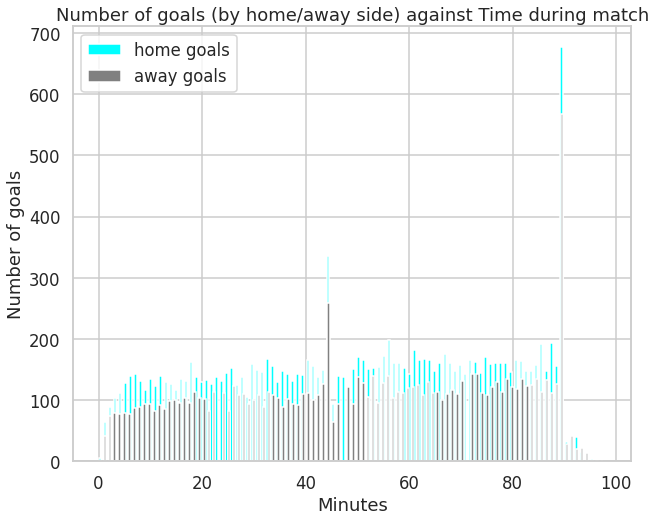

In [ ]:
fig = plot.figure(figsize=(10,8))
plot.hist(goals_scored[goals_scored["side"]==1]["time"],width=0.5,bins=100,color="cyan",label="home goals")   
plot.hist(goals_scored[goals_scored["side"]==2]["time"],width=0.5,bins=100,color="grey",label="away goals") 
plot.xlabel("Minutes")
plot.ylabel("Number of goals")
plot.legend()
plot.title("Number of goals (by home/away side) against Time during match")

### From the above graph we can infer that maximum number of goals were scored between 40 to 50 minutes in a match by both Home and away Team. 

### Let's Visualize the count of red cards the Home and Away teams got. 

In [ ]:
# filtering data to get the count of total red cards 
yellow_second_card=game_events[game_events["event_type"]==5]
red_card=game_events[game_events["event_type"]==6]
reds_total=[yellow_second_card,red_card]
total_red_cards=pd.concat(reds_total)
total_red_cards.event_type.unique()

array([5, 6])

,home,away
Red cards,548,704


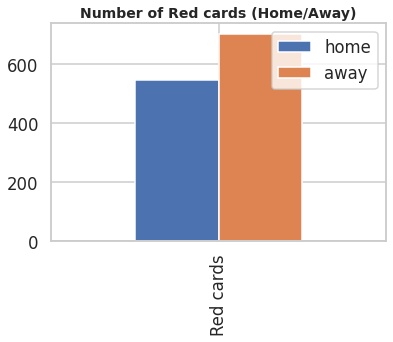

In [ ]:
red_home=total_red_cards[total_red_cards["side"]==1].shape[0]
red_away=total_red_cards[total_red_cards["side"]==2].shape[0]

red_combined=pd.DataFrame({"home":red_home,"away":red_away},index=["Red cards"])
red_combined.plot(kind="bar")
plot.title("Number of Red cards (Home/Away)",fontname="Times New Roman Bold",fontsize=14,fontweight="bold")
red_combined

### From the above graph its pretty clear that Home team has played much better since they got less number of Red cards as compared to the Away Team.

In [ ]:
# common function to plot bar plots with following configuration
def barplot(data, x_ticks, x_labels, y_labels, title, color='muted', num=10, figsize=8):
    # set whitegrid as style
    sns.set_style("whitegrid")
    
    plot.figure(figsize=(num, figsize))
    # plot data
    bx = sns.barplot(x = [j for j in range(0, len(data))], y=data.values, palette=color)
    # set ticks 
    bx.set_xticks([j for j in range(0, len(data))])
    # set labels on the chart
    bx.set_xticklabels(x_ticks, rotation=45)
    bx.set(xlabel = x_labels, ylabel = y_labels, title = title)
    bx.plot();
    plot.tight_layout()

## **Which Teams are most offensive in the matches played?**

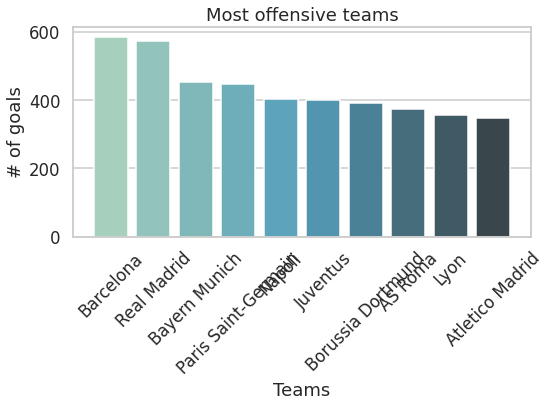

In [ ]:
# group attempts by team
group_by_offensive = game_events[game_events['is_goal']==1].groupby('event_team')

# sort the values grouped
group_by_offensive = group_by_offensive.count().sort_values(by='id_event', ascending=False)[:10]
teams = group_by_offensive.index
scores = group_by_offensive['id_event']

# plot the teams
barplot(scores, teams, 'Teams', '# of goals', 'Most offensive teams', 'GnBu_d', 8, 6)

### The above graph shows an interesting goal scores for the top teams. Barcelona tops this tally, rest of the teams also have scored good number of goals. 
### Similar to the above graph, I can also plot the graph to see the most offensive players in the league. 

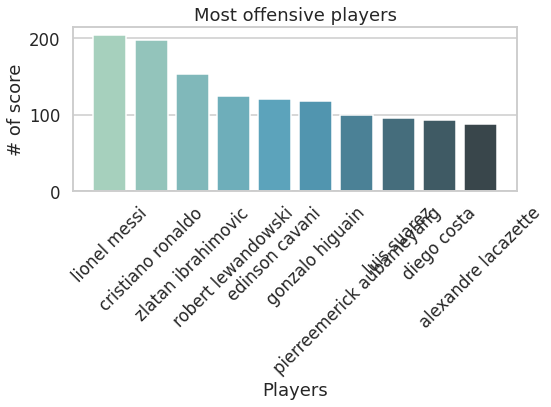

In [ ]:
# group by player if the goal is scored
group_by_player = game_events[game_events['is_goal']==1].groupby('player')

# count and sort the number of goals by player and pick top 10
group_by_offensive_player = group_by_player.count().sort_values(by='id_event',
                                                                                ascending=False)[:10]
# extract player names
players = group_by_offensive_player.index
# extract number of goals
scores = group_by_offensive_player['id_event']
# plot the graph
barplot(scores, players, 'Players', '# of score', 'Most offensive players', 'GnBu_d', 8, 6)

Clearly Lionel Messi and Ronaldo are the most Offensive players in the top 10 most offensive teams in the league.

# **Clustering**

## The main aim here is to cluster the teams which participated in the league matches on the basis of their playing style.


As a part of this I have used parameters such as events (fouls, attempts, ...), locations (midfield,wings,etc ...), assist methods (crosses,short passes ...), situations (different set pieces and open play) and involved body parts(both feet and head).

In [ ]:
goals=game_events[game_events['shot_outcome']==1] #1 is on target
goals=goals[goals['text'].apply(lambda x:'Goal' in x)]
goals.head(2)

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
13,UFot0hit/,UFot0hit14,14,17,"Goal! Borussia Dortmund 1, Hamburg 0. Kevin G...",1,12.0,1,Borussia Dortmund,Hamburg SV,kevin grosskreutz,mario gotze,0,0,4.0,1.0,1,9.0,2.0,1,1.0,0
26,UFot0hit/,UFot0hit27,27,29,"Goal! Borussia Dortmund 2, Hamburg 0. Mario G...",1,12.0,1,Borussia Dortmund,Hamburg SV,mario gotze,robert lewandowski,0,0,5.0,1.0,1,3.0,1.0,1,1.0,0


# **Feature Selection**

In [ ]:
# count all the required parameter and then group them based on teams
# select relevant feature from the dataset
game_df = game_events[['event_team','is_goal', 'event_type', 'event_type2','location', 'assist_method', 'situation', 'bodypart']]
game_df.head()


,event_team,is_goal,event_type,event_type2,location,assist_method,situation,bodypart
0,Hamburg SV,0,1,12.0,9.0,1,1.0,2.0
1,Borussia Dortmund,0,2,0.0,0.0,0,0.0,0.0
2,Borussia Dortmund,0,2,0.0,0.0,0,0.0,0.0
3,Borussia Dortmund,0,3,0.0,0.0,0,0.0,0.0
4,Hamburg SV,0,8,0.0,2.0,0,0.0,0.0


## Combining the total count of yellow cards, total fouls, red cards, attempts, goals for the teams. Grouping them by the teams.

In [ ]:
# yellow card count
yellow_cards=(game_df.groupby('event_team')['event_type'].apply(lambda x: (x==4).sum())
       +game_df.groupby('event_team')['event_type'].apply(lambda x: (x==5).sum()))
yellow_cards.head(3)

event_team
AC Ajaccio    238
AC Milan      502
AJ Auxerre     89
Name: event_type, dtype: int64

In [ ]:
# total foul count
total_foul=game_df.groupby('event_team')['event_type'].apply(lambda x: (x==3).sum()) 
total_foul.head(3)

event_team
AC Ajaccio    1593
AC Milan      2677
AJ Auxerre     558
Name: event_type, dtype: int64

In [ ]:
# red card count
red_cards=game_df.groupby('event_team')['event_type'].apply(lambda x: (x==6).sum()) #red_cards
red_cards.head(3)

event_team
AC Ajaccio    12
AC Milan      18
AJ Auxerre     3
Name: event_type, dtype: int64

In [ ]:
assist_method=game_df.dropna().groupby('event_team')['assist_method'].value_counts()
assist_method.head(3)

event_team  assist_method
AC Ajaccio  0                4953
            1                 490
            2                 198
Name: assist_method, dtype: int64

In [ ]:
# total goals per team
num_goals=goals.groupby('event_team')['is_goal'].count()
num_goals.head(3)

event_team
AC Ajaccio    110
AC Milan      320
AJ Auxerre     46
Name: is_goal, dtype: int64

In [ ]:
# total attempts
attempts=game_df.groupby('event_team')['event_type'].apply(lambda x: (x==1).sum()) #attempts
attempts.head(3)

event_team
AC Ajaccio    1106
AC Milan      3065
AJ Auxerre     446
Name: event_type, dtype: int64

In [ ]:
situation=game_df.dropna().groupby('event_team')['situation'].value_counts()
situation.head(2)

event_team  situation
AC Ajaccio  0.0          4609
            1.0           913
Name: situation, dtype: int64

In [ ]:
location=game_df.dropna().groupby('event_team')['location'].value_counts()
location.head(2)

event_team  location
AC Ajaccio  0.0         3075
            2.0          850
Name: location, dtype: int64

In [ ]:
game_df1=pd.concat([yellow_cards,attempts,total_foul,red_cards],axis=1)
game_df1.columns=['yellow_cards','attempts','total_foul','red_cards']
game_df1.head(3)

,yellow_cards,attempts,total_foul,red_cards
event_team,,,,
AC Ajaccio,238,1106,1593,12
AC Milan,502,3065,2677,18
AJ Auxerre,89,446,558,3


In [ ]:
df = game_df.iloc[:,4:7]
df.columns

Index(['location', 'assist_method', 'situation'], dtype='object')

In [ ]:
# mapping the values of the mentioned columns with the dictinary options
mapping=dict()
for col in ['situation','location','assist_method']:
    uniq=game_df[col].unique().tolist()
    l=[]
    for i in uniq:
        sample=game_df[game_df[col]==i]
        l.append(sample.dropna().groupby('event_team')[col].count())
    mapping[col]=l

In [ ]:
game_df1['team'] = game_df1.index 
game_df1['goals']=num_goals
game_df1

,yellow_cards,attempts,total_foul,red_cards,team,goals
event_team,,,,,,
AC Ajaccio,238,1106,1593,12,AC Ajaccio,110
AC Milan,502,3065,2677,18,AC Milan,320
AJ Auxerre,89,446,558,3,AJ Auxerre,46
AS Monaco,243,1665,1666,8,AS Monaco,228
AS Nancy Lorraine,160,1058,1260,7,AS Nancy Lorraine,87
...,...,...,...,...,...,...
Villarreal,393,1849,2045,5,Villarreal,203
Watford,130,678,725,4,Watford,64
Werder Bremen,375,2318,2645,10,Werder Bremen,249


In [ ]:
# breaking the below columns into seperate option columns
for i in ['situation','location','assist_method']:
    uniq=game_df[i].unique().tolist()
    l=[]
    for j in range(len(uniq)):
        game_df1[i+'_'+str(uniq[j])]=game_df1['team'].map(mapping[i][j].to_dict())
game_df1

,yellow_cards,attempts,total_foul,red_cards,team,goals,situation_1.0,situation_0.0,situation_3.0,situation_4.0,situation_2.0,location_9.0,location_0.0,location_2.0,location_4.0,location_15.0,location_1.0,location_3.0,location_5.0,location_11.0,location_13.0,location_16.0,location_17.0,location_7.0,location_8.0,location_12.0,location_10.0,location_19.0,location_6.0,location_14.0,location_18.0,assist_method_1,assist_method_0,assist_method_2,assist_method_3,assist_method_4
event_team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC Ajaccio,238,1106,1593,12,AC Ajaccio,110,913,4609,74,33,86,71,3075,850,212,457,285,336,187,92,27,24.0,20.0,9.0,10.0,12,13,8.0,9.0,15,3.0,490,4953,198,43,31.0
AC Milan,502,3065,2677,18,AC Milan,320,2615,8568,219,87,144,215,5728,1484,344,1465,673,784,339,256,93,23.0,19.0,28.0,35.0,29,34,22.0,10.0,51,1.0,1556,9433,477,61,106.0
AJ Auxerre,89,446,558,3,AJ Auxerre,46,364,1538,41,23,18,48,1069,237,70,173,108,123,54,33,18,5.0,8.0,4.0,4.0,10,10,2.0,6.0,1,1.0,174,1682,92,16,20.0
AS Monaco,243,1665,1666,8,AS Monaco,228,1387,5185,142,50,86,131,3449,848,221,607,407,558,260,128,56,11.0,9.0,19.0,16.0,44,32,18.0,8.0,26,2.0,754,5631,363,49,53.0
AS Nancy Lorraine,160,1058,1260,7,AS Nancy Lorraine,87,874,3522,86,29,69,85,2348,618,172,502,239,261,145,82,28,17.0,16.0,11.0,4.0,14,15,4.0,7.0,10,2.0,523,3789,193,42,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Villarreal,393,1849,2045,5,Villarreal,203,1578,6399,146,42,83,164,4314,1150,235,709,476,512,224,191,64,9.0,10.0,35.0,26.0,46,34,11.0,11.0,24,3.0,924,6892,295,43,94.0
Watford,130,678,725,4,Watford,64,574,2016,46,12,46,53,1377,328,92,296,143,205,76,49,14,1.0,8.0,14.0,6.0,9,9,4.0,1.0,9,NaN,301,2229,117,42,5.0
Werder Bremen,375,2318,2645,10,Werder Bremen,249,1912,7657,208,49,149,184,4943,1540,296,885,529,726,349,184,70,34.0,15.0,26.0,31.0,42,50,17.0,24.0,27,3.0,1082,8331,415,108,39.0


### Since various teams can have different number of games, I haved counted games for each team both home and away. After counting I have normalize all features by the total number of games.

In [ ]:
# get rid of all the decimal numbers in the column names
game_df1.rename(columns={'location_10.0': 'location_10'}, inplace = True)

for col in game_df1.columns:   
    if col.endswith('.0'):
        col1 = col.strip('.0')
    else:
        col1 = col
    game_df1 = game_df1.rename(columns={col : col1})   

print(game_df1.columns)


Index(['yellow_cards', 'attempts', 'total_foul', 'red_cards', 'team', 'goals',
       'situation_1', 'situation_', 'situation_3', 'situation_4',
       'situation_2', 'location_9', 'location_', 'location_2', 'location_4',
       'location_15', 'location_1', 'location_3', 'location_5', 'location_11',
       'location_13', 'location_16', 'location_17', 'location_7', 'location_8',
       'location_12', 'location_10', 'location_19', 'location_6',
       'location_14', 'location_18', 'assist_method_1', 'assist_method_0',
       'assist_method_2', 'assist_method_3', 'assist_method_4'],
      dtype='object')


In [ ]:
game = game_info['ht'].value_counts() + game_info['at'].value_counts()
game_df1['games'] = game
game_df1.head(5)

,yellow_cards,attempts,total_foul,red_cards,team,goals,situation_1,situation_,situation_3,situation_4,situation_2,location_9,location_,location_2,location_4,location_15,location_1,location_3,location_5,location_11,location_13,location_16,location_17,location_7,location_8,location_12,location_10,location_19,location_6,location_14,location_18,assist_method_1,assist_method_0,assist_method_2,assist_method_3,assist_method_4,games
event_team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC Ajaccio,238,1106,1593,12,AC Ajaccio,110,913,4609,74,33,86,71,3075,850,212,457,285,336,187,92,27,24.0,20.0,9.0,10.0,12,13,8.0,9.0,15,3.0,490,4953,198,43,31.0,114.0
AC Milan,502,3065,2677,18,AC Milan,320,2615,8568,219,87,144,215,5728,1484,344,1465,673,784,339,256,93,23.0,19.0,28.0,35.0,29,34,22.0,10.0,51,1.0,1556,9433,477,61,106.0,210.0
AJ Auxerre,89,446,558,3,AJ Auxerre,46,364,1538,41,23,18,48,1069,237,70,173,108,123,54,33,18,5.0,8.0,4.0,4.0,10,10,2.0,6.0,1,1.0,174,1682,92,16,20.0,38.0
AS Monaco,243,1665,1666,8,AS Monaco,228,1387,5185,142,50,86,131,3449,848,221,607,407,558,260,128,56,11.0,9.0,19.0,16.0,44,32,18.0,8.0,26,2.0,754,5631,363,49,53.0,135.0
AS Nancy Lorraine,160,1058,1260,7,AS Nancy Lorraine,87,874,3522,86,29,69,85,2348,618,172,502,239,261,145,82,28,17.0,16.0,11.0,4.0,14,15,4.0,7.0,10,2.0,523,3789,193,42,33.0,96.0


In [ ]:
for i in game_df1.columns: 
    if (type(game_df1[i][0]) == np.float64) | (type(game_df1[i][0]) == np.int64):
        game_df1[i] = game_df1[i].div(game, axis=0)

### **Mapping the parameter names with the names provided in the dictionary.**

In [ ]:
from re import A
f = open(dict_path,"r")
a = []
b = []
r = []
for lines in f:
    a.append(lines.split())

line_base = a[0][0]

for line in a:
    if len(line) > 1:        
        ll = ''
        for j in range(1, len(line)):
            if j < (len(line) - 1):
                ll = ll + line[j] + ' '
            else:
                ll = ll + line[j]
        b.append([line_base + '_' + line[0], ll])
                
    elif len(line) == 1:
        line_base = line[0]
print(b)

[['event_type_0', 'Announcement'], ['event_type_1', 'Attempt'], ['event_type_2', 'Corner'], ['event_type_3', 'Foul'], ['event_type_4', 'Yellow card'], ['event_type_5', 'Second yellow card'], ['event_type_6', 'Red card'], ['event_type_7', 'Substitution'], ['event_type_8', 'Free kick won'], ['event_type_9', 'Offside'], ['event_type_10', 'Hand ball'], ['event_type_11', 'Penalty conceded'], ['event_type2_12', 'Key Pass'], ['event_type2_13', 'Failed through ball'], ['event_type2_14', 'Sending off'], ['event_type2_15', 'Own goal'], ['side_1', 'Home'], ['side_2', 'Away'], ['shot_place_1', 'Bit too high'], ['shot_place_2', 'Blocked'], ['shot_place_3', 'Bottom left corner'], ['shot_place_4', 'Bottom right corner'], ['shot_place_5', 'Centre of the goal'], ['shot_place_6', 'High and wide'], ['shot_place_7', 'Hits the bar'], ['shot_place_8', 'Misses to the left'], ['shot_place_9', 'Misses to the right'], ['shot_place_10', 'Too high'], ['shot_place_11', 'Top centre of the goal'], ['shot_place_12', 

In [ ]:
i = 0
for col in b:    
    if col[0] in game_df1.columns:        
        game_df1 = game_df1.rename(columns={col[0] : col[1]})
    
print(game_df1.columns)

Index(['yellow_cards', 'attempts', 'total_foul', 'red_cards', 'team', 'goals',
       'Open play', 'situation_', 'Corner', 'Free kick', 'Set piece',
       'Left side of the box', 'location_', 'Defensive half', 'Left wing',
       'Outside the box', 'Attacking half', 'Centre of the box', 'Right wing',
       'Right side of the box', 'Very close range', 'Long range',
       'More than 35 yards', 'Difficult angle on the left',
       'Difficult angle on the right', 'Right side of the six yard box',
       'Left side of the six yard box', 'Not recorded',
       'Difficult angle and long range', 'Penalty spot', 'More than 40 yards',
       'Pass', 'None', 'Cross', 'Headed pass', 'Through ball', 'games'],
      dtype='object')


In [ ]:
game_df1.drop(['games'], axis=1, inplace=True)

In [ ]:
# merge columns since playing style is not distinguish by right from left.
def col_sum(a1,b1):
    c1 = game_df1[[a1,b1]].sum(axis=1)    
    game_df1.drop([a1,b1], axis=1, inplace=True)
    return c1    
game_df1['Difficult angle'] = col_sum('Difficult angle on the left','Difficult angle on the right')
game_df1['Side of the box'] = col_sum('Left side of the box','Right side of the box')
game_df1['Side of the six yard box'] = col_sum('Left side of the six yard box','Right side of the six yard box')

Doing some cleaning in the data.

In [ ]:
game_df1.rename(columns={'head': 'Head'}, inplace = True) 

In [ ]:
game_df1.dropna(axis=0,inplace=True)

In [ ]:
game_df1.head()

,yellow_cards,attempts,total_foul,red_cards,team,goals,Open play,situation_,Corner,Free kick,Set piece,location_,Defensive half,Left wing,Outside the box,Attacking half,Centre of the box,Right wing,Very close range,Long range,More than 35 yards,Not recorded,Difficult angle and long range,Penalty spot,More than 40 yards,Pass,None,Cross,Headed pass,Through ball,Difficult angle,Side of the box,Side of the six yard box
event_team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC Ajaccio,2.087719,9.701754,13.973684,0.105263,AC Ajaccio,0.964912,8.008772,40.429825,0.649123,0.289474,0.754386,26.973684,7.456140,1.859649,4.008772,2.500000,2.947368,1.640351,0.236842,0.210526,0.175439,0.070175,0.078947,0.131579,0.026316,4.298246,43.447368,1.736842,0.377193,0.271930,0.166667,1.429825,0.219298
AC Milan,2.390476,14.595238,12.747619,0.085714,AC Milan,1.523810,12.452381,40.800000,1.042857,0.414286,0.685714,27.276190,7.066667,1.638095,6.976190,3.204762,3.733333,1.614286,0.442857,0.109524,0.090476,0.104762,0.047619,0.242857,0.004762,7.409524,44.919048,2.271429,0.290476,0.504762,0.300000,2.242857,0.300000
AJ Auxerre,2.342105,11.736842,14.684211,0.078947,AJ Auxerre,1.210526,9.578947,40.473684,1.078947,0.605263,0.473684,28.131579,6.236842,1.842105,4.552632,2.842105,3.236842,1.421053,0.473684,0.131579,0.210526,0.052632,0.157895,0.026316,0.026316,4.578947,44.263158,2.421053,0.421053,0.526316,0.210526,2.131579,0.526316
AS Monaco,1.800000,12.333333,12.340741,0.059259,AS Monaco,1.688889,10.274074,38.407407,1.051852,0.370370,0.637037,25.548148,6.281481,1.637037,4.496296,3.014815,4.133333,1.925926,0.414815,0.081481,0.066667,0.133333,0.059259,0.192593,0.014815,5.585185,41.711111,2.688889,0.362963,0.392593,0.259259,1.918519,0.562963
AS Nancy Lorraine,1.666667,11.020833,13.125000,0.072917,AS Nancy Lorraine,0.906250,9.104167,36.687500,0.895833,0.302083,0.718750,24.458333,6.437500,1.791667,5.229167,2.489583,2.718750,1.510417,0.291667,0.177083,0.166667,0.041667,0.072917,0.104167,0.020833,5.447917,39.468750,2.010417,0.437500,0.343750,0.156250,1.739583,0.302083


## Applying k-mean elbow method to check the number of clusters needed.

In [ ]:
X=game_df1[['total_foul', 'goals']]
column_names =['total_foul', 'goals']

In [ ]:
scalar = MinMaxScaler()
X[column_names] = scalar.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


I have used the 2 features from the dataset to plot the elbow graph.

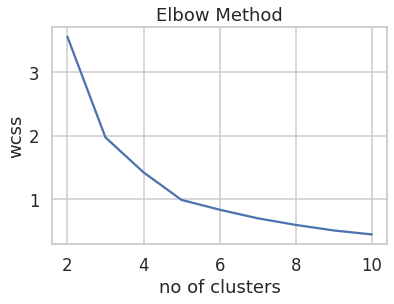

In [ ]:
from sklearn.cluster import KMeans
wcss=[]
for i in range(2,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans_model = kmeans.fit(X)
    wcss.append(kmeans.inertia_)     
plot.plot(range(2,11), wcss,)
plot.title('Elbow Method')
plot.xlabel('no of clusters')
plot.ylabel('wcss')
plot.show()

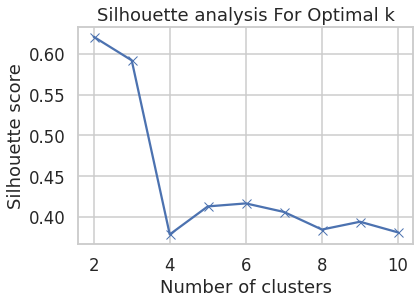

In [ ]:
# Sillhoutte Score calculation 
range_of_clusters = range(2, 11)
silhouette_avgerage = []
for num_clusters in range_of_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avgerage.append(silhouette_score(X, cluster_labels))
plot.plot(range_of_clusters,silhouette_avgerage,'bx-')


plot.xlabel('Number of clusters')
plot.ylabel('Silhouette score')
plot.title('Silhouette analysis For Optimal k')
plot.show()

### Based on the result of elbow method we can get the number of cluster=4

### Selecting relevant features for applying clustering.

I have plotted clusters with labels to see positions of the clusters. I have used fouls per attempt as the basic features.

In [ ]:
colors = ['b', 'g', 'r','y']
markers = ['o', 'v', 's','+']
kmeans_model = KMeans(4).fit(X)
X['kmeans_cluster'] = kmeans_model.predict(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


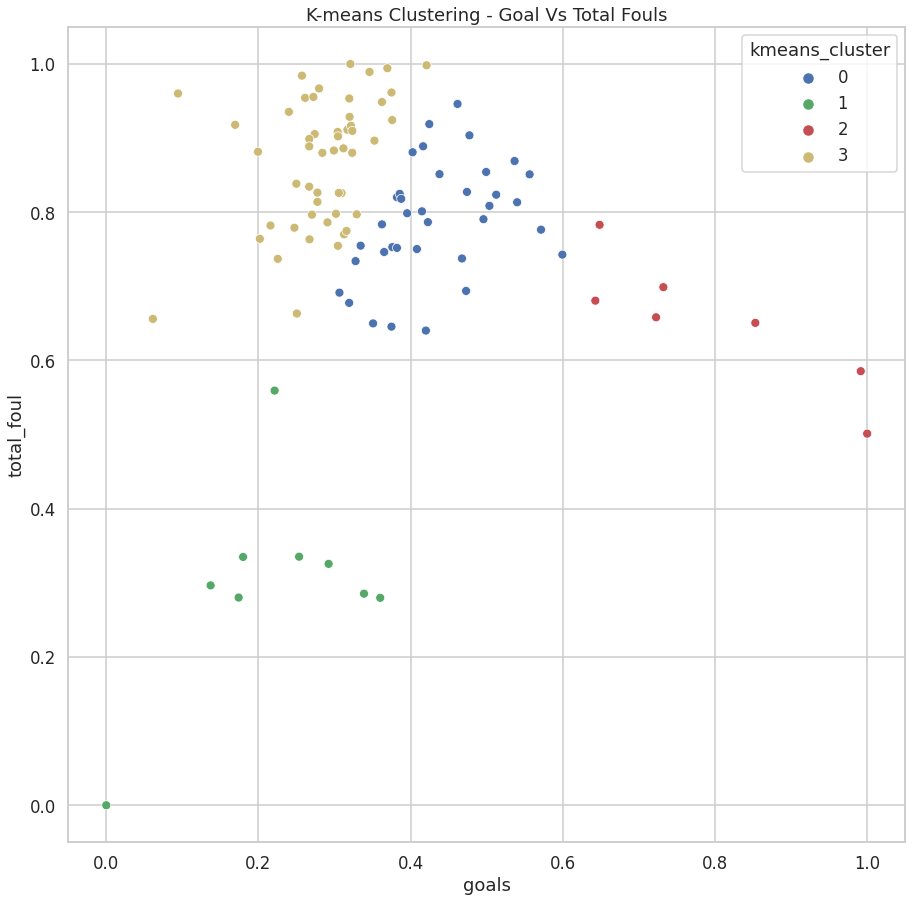

In [ ]:
sns.set_context('talk')
plot.figure(figsize=(15,15))
sns.scatterplot(x=X['goals'],y=X['total_foul'],hue=X['kmeans_cluster'], palette=colors)
plot.title('K-means Clustering - Goal Vs Total Fouls')
plot.show()

From the above plot, I have the following clusters:-

*   Cluster 0 - Teams with average Goal and average number of fouls.
*   Cluster 1 - Teams with less Goals and less number of fouls
*   Cluster 2 - Teams with more Goals and less number of fouls.
*   Cluster 3 - Teams with less Goals and high number of fouls. These teams need to perform well.

## **Clustering Using GMM algorithm**

In [ ]:
game_df1

,yellow_cards,attempts,total_foul,red_cards,team,goals,Open play,situation_,Corner,Free kick,Set piece,location_,Defensive half,Left wing,Outside the box,Attacking half,Centre of the box,Right wing,Very close range,Long range,More than 35 yards,Not recorded,Difficult angle and long range,Penalty spot,More than 40 yards,Pass,None,Cross,Headed pass,Through ball,Difficult angle,Side of the box,Side of the six yard box
event_team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC Ajaccio,2.087719,9.701754,13.973684,0.105263,AC Ajaccio,0.964912,8.008772,40.429825,0.649123,0.289474,0.754386,26.973684,7.456140,1.859649,4.008772,2.500000,2.947368,1.640351,0.236842,0.210526,0.175439,0.070175,0.078947,0.131579,0.026316,4.298246,43.447368,1.736842,0.377193,0.271930,0.166667,1.429825,0.219298
AC Milan,2.390476,14.595238,12.747619,0.085714,AC Milan,1.523810,12.452381,40.800000,1.042857,0.414286,0.685714,27.276190,7.066667,1.638095,6.976190,3.204762,3.733333,1.614286,0.442857,0.109524,0.090476,0.104762,0.047619,0.242857,0.004762,7.409524,44.919048,2.271429,0.290476,0.504762,0.300000,2.242857,0.300000
AJ Auxerre,2.342105,11.736842,14.684211,0.078947,AJ Auxerre,1.210526,9.578947,40.473684,1.078947,0.605263,0.473684,28.131579,6.236842,1.842105,4.552632,2.842105,3.236842,1.421053,0.473684,0.131579,0.210526,0.052632,0.157895,0.026316,0.026316,4.578947,44.263158,2.421053,0.421053,0.526316,0.210526,2.131579,0.526316
AS Monaco,1.800000,12.333333,12.340741,0.059259,AS Monaco,1.688889,10.274074,38.407407,1.051852,0.370370,0.637037,25.548148,6.281481,1.637037,4.496296,3.014815,4.133333,1.925926,0.414815,0.081481,0.066667,0.133333,0.059259,0.192593,0.014815,5.585185,41.711111,2.688889,0.362963,0.392593,0.259259,1.918519,0.562963
AS Nancy Lorraine,1.666667,11.020833,13.125000,0.072917,AS Nancy Lorraine,0.906250,9.104167,36.687500,0.895833,0.302083,0.718750,24.458333,6.437500,1.791667,5.229167,2.489583,2.718750,1.510417,0.291667,0.177083,0.166667,0.041667,0.072917,0.104167,0.020833,5.447917,39.468750,2.010417,0.437500,0.343750,0.156250,1.739583,0.302083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VfB Stuttgart,1.917647,12.223529,13.764706,0.064706,VfB Stuttgart,1.311765,9.994118,40.300000,1.117647,0.305882,0.805882,26.547059,7.335294,1.917647,4.423529,3.070588,3.888235,1.429412,0.541176,0.200000,0.100000,0.047059,0.111765,0.123529,0.011765,5.735294,43.570588,2.494118,0.529412,0.194118,0.294118,2.105882,0.376471
VfL Wolfsburg,1.684492,12.994652,13.951872,0.048128,VfL Wolfsburg,1.459893,10.978610,39.780749,1.213904,0.267380,0.534759,26.395722,7.213904,1.486631,5.016043,2.786096,4.229947,1.898396,0.497326,0.139037,0.144385,0.101604,0.106952,0.085561,0.010695,6.631016,42.625668,2.807487,0.454545,0.256684,0.256684,1.962567,0.443850
Villarreal,2.298246,10.812865,11.959064,0.029240,Villarreal,1.187135,9.228070,37.421053,0.853801,0.245614,0.485380,25.228070,6.725146,1.374269,4.146199,2.783626,2.994152,1.309942,0.374269,0.052632,0.058480,0.064327,0.064327,0.140351,0.017544,5.403509,40.304094,1.725146,0.251462,0.549708,0.356725,2.076023,0.467836


In [ ]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

## **To find optimal number of clusters performing Silhouette analysis**

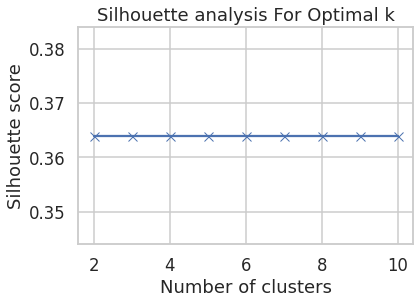

In [ ]:
# calculate the Sillhoutte Score

range_of_clusters = range(2, 11)
silhouette_avgerage = []
for num_clusters in range_of_clusters:
  gmm = GaussianMixture(n_components=i,covariance_type="full", random_state=0)
  gmm.fit(X)

  labels = gmm.predict(X)
  silhouette_avgerage.append(silhouette_score(X, labels, metric = 'euclidean', random_state=0))
  
 
  # plot silhouette score
plot.plot(range_of_clusters,silhouette_avgerage,'bx-')
plot.xlabel('Number of clusters')
plot.ylabel('Silhouette score')
plot.title('Silhouette analysis For Optimal k')
plot.show()

In [ ]:
gmm_clust = GaussianMixture(n_components=4)
gmm_clust.fit(X)

GaussianMixture(n_components=4)

In [ ]:
X['gmm_cluster'] = gmm_clust.predict(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


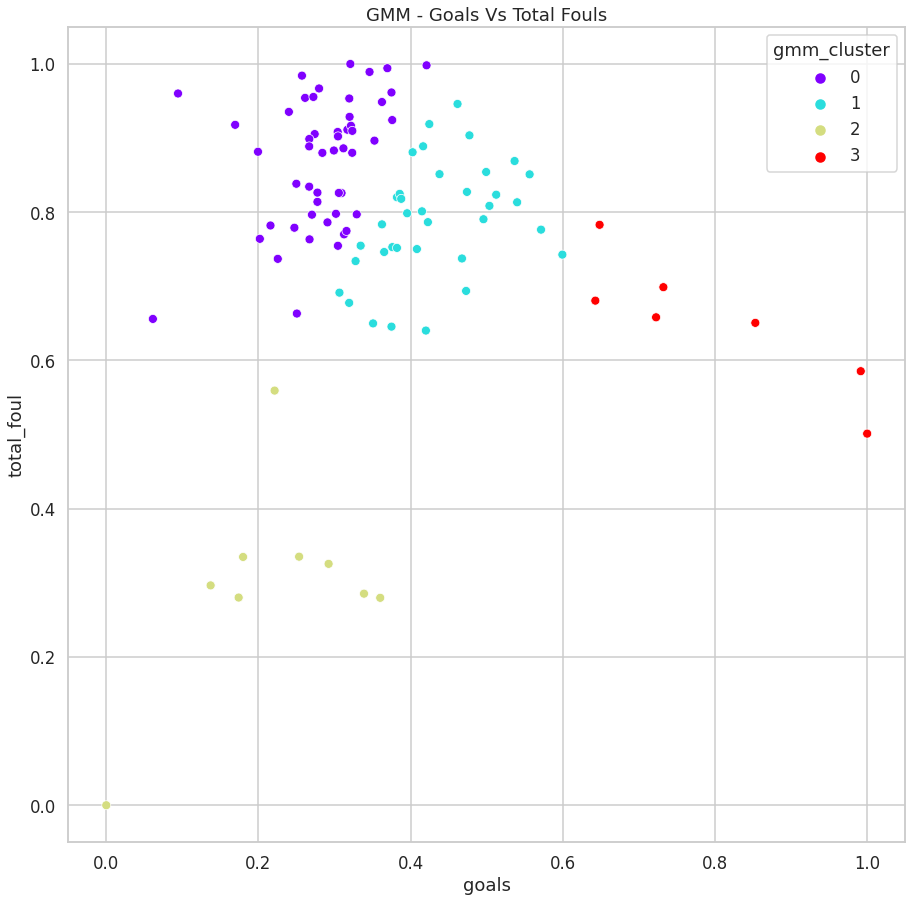

In [ ]:
# plot GMM clusters
sns.set_context('talk')
plot.figure(figsize=(15,15))
sns.scatterplot(x=X['goals'],y=X['total_foul'],hue=X['gmm_cluster'], palette='rainbow')
plot.title('GMM - Goals Vs Total Fouls')
plot.show()

From the above scatterplot, following clusters can be inferenced:-

*   Cluster 0 - Teams with average Goal and average number of total fouls.
*   Cluster 1 - Team with less Goals and less number of total fouls.
*   Cluster 2 - Teams with less Goals and more number of total fouls. Indicates the poor performing teams.
*   Cluster 3 - Teams with more Goals but less number of total fouls. These teams are performing better than others.  

The K-means and Gaussian Misture provides a similar results for clustering.

## **Hierarchical Clustering**

In [ ]:
X=X[['total_foul', 'goals']]
column_names =['total_foul', 'goals']
from sklearn.preprocessing import normalize
data_scaled = normalize(X)
data_scaled = pd.DataFrame(data_scaled, columns=X.columns)
data_scaled.head()

,total_foul,goals
0,0.957158,0.289565
1,0.848858,0.528621
2,0.931710,0.363203
3,0.805430,0.592691
4,0.958362,0.285556


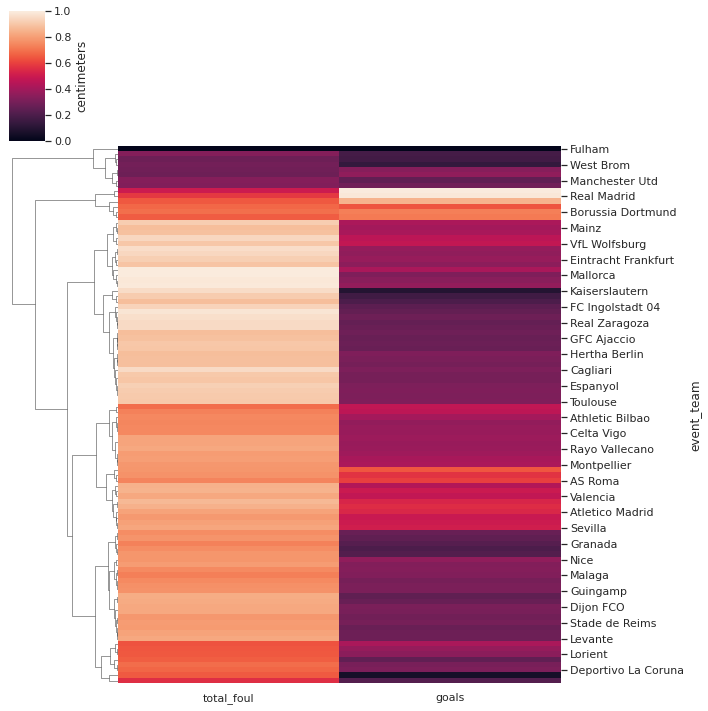

In [ ]:
import seaborn as sns; sns.set(color_codes=True)
sns.clustermap(X, method="ward", col_cluster=False, cbar_kws={'label': 'centimeters'});

### From the above heat map it can be infered tha I can create 4 clusters.
### I have also drawn a dendogram to decide the number of clusters for the dataset with the above 2 features.

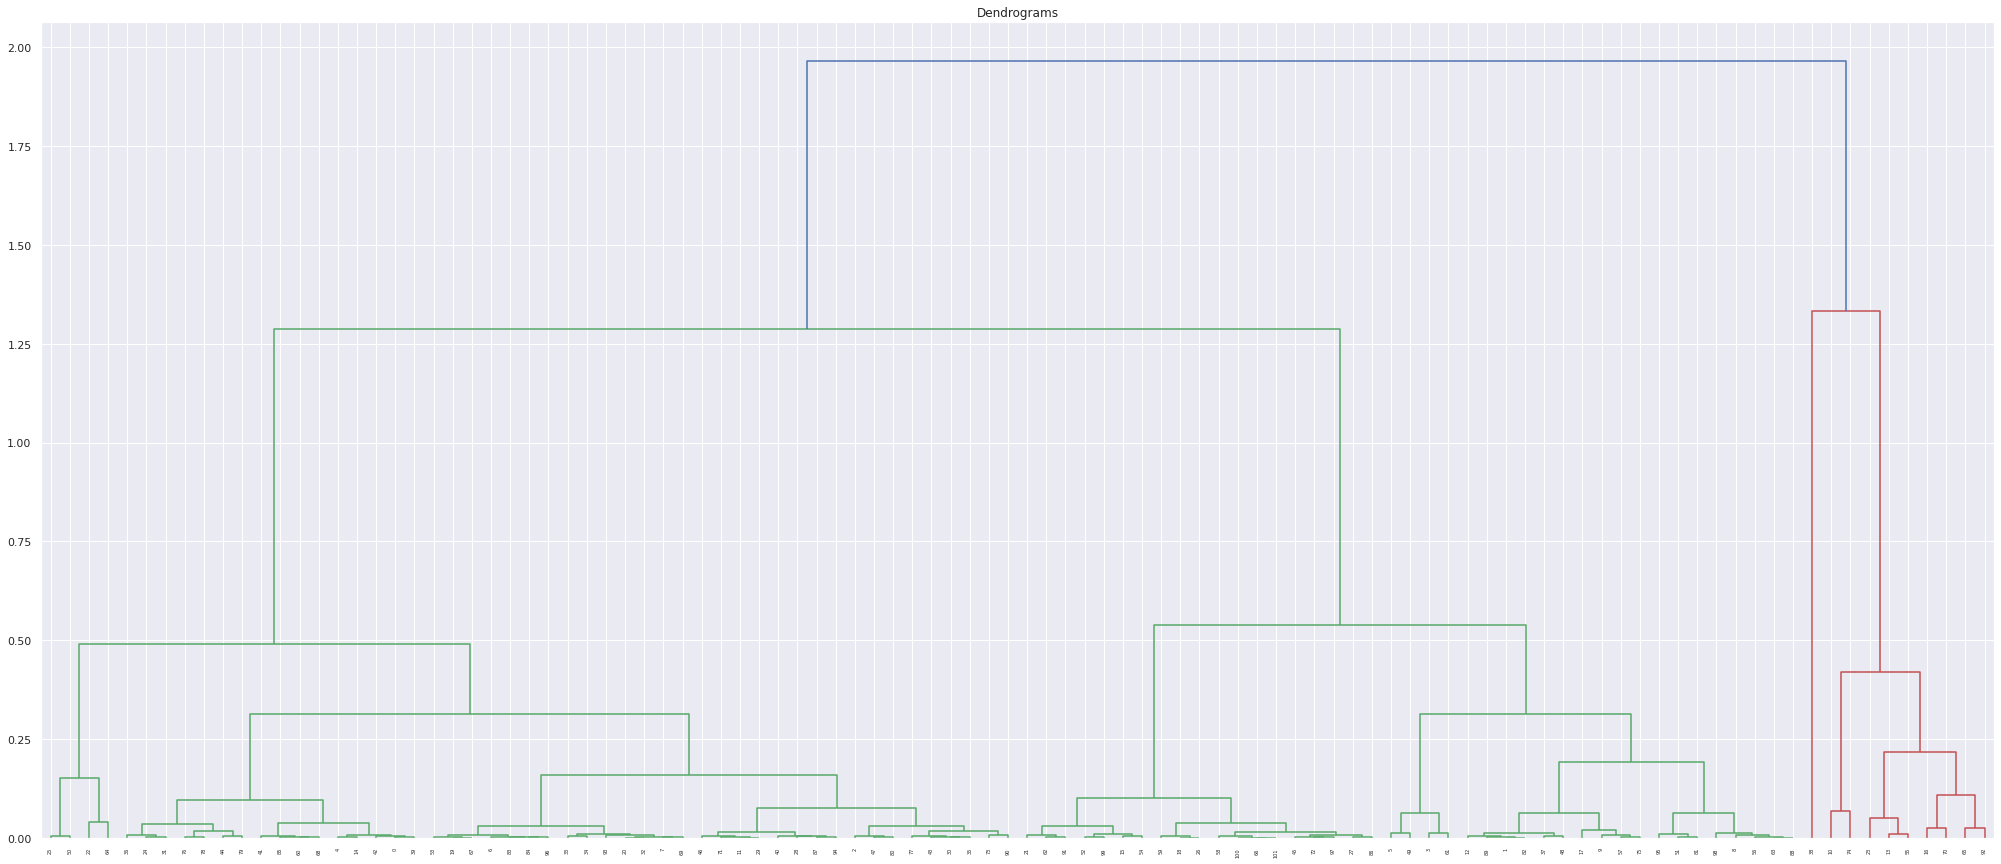

In [ ]:
import scipy.cluster.hierarchy as shc
plot.figure(figsize=(35, 15))  
plot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

In the above graph the x-axis contains the sample and the y-axis contains the distance between each samples.

In [ ]:
# used Agglomerative Clustering with euclidean distance and created a distance matrix
from sklearn.cluster import AgglomerativeClustering
clusters = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
heir_cluster = clusters.fit_predict(data_scaled)

In [ ]:
X['heirarchical_cluster'] = heir_cluster

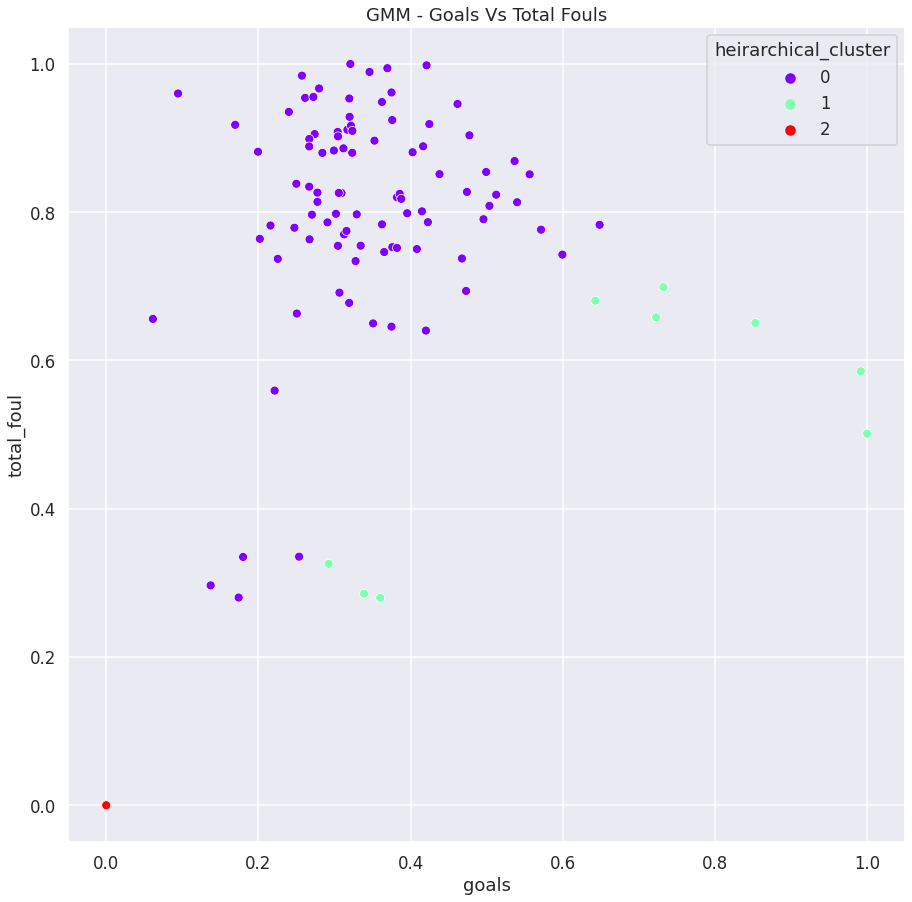

In [ ]:
sns.set_context('talk')
plot.figure(figsize=(15,15))
sns.scatterplot(x=X['goals'],y=X['total_foul'],hue=X['heirarchical_cluster'], palette='rainbow')
plot.title('GMM - Goals Vs Total Fouls')
plot.show()

I have infered the following clusters from the above plot:

*   Cluster 0 - Team with more fouls and average number of goals
*   Cluster 1 - Team with less fouls and more number of goals.These teams are suppose to be playing better then other teams.
*   Cluster 2 - Teams with less Goals and less number of fouls - This indicates the teams are not performing good in the matches.

The K-means,Gaussian Mixture provides similar results but heirarchical clustering provides different clusters.